### Задача
Дана статистика пользователей adult.csv.
Получите значения AUC для различных моделей и их параметров.
Используйте как минимум 3 различные модели классификации.
Решением будет ссылка на гитхаб с ноутбуком.

#### Импорт библиотек

In [10]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

#### Загрузка данных

In [11]:
data = pd.read_csv('adult.csv')
data.head(3)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K


In [12]:
# разделение данных на количественные и категориальные
categorial_columns = []
numeric_columns = []
    
def column_types(data):

    for i in data.columns:
        if data[i].dtype == 'object':
            categorial_columns.append(i)
        else:
            numeric_columns.append(i)
            
    return categorial_columns, numeric_columns
            
column_types(data)

(['workclass',
  'education',
  'marital-status',
  'occupation',
  'relationship',
  'race',
  'gender',
  'native-country',
  'income'],
 ['age',
  'fnlwgt',
  'educational-num',
  'capital-gain',
  'capital-loss',
  'hours-per-week'])

### Анализ категориальных данных

In [13]:
# вывод уникальных значений
for i in data[categorial_columns]:
    print(data[i].unique().T)

['Private' 'Local-gov' '?' 'Self-emp-not-inc' 'Federal-gov' 'State-gov'
 'Self-emp-inc' 'Without-pay' 'Never-worked']
['11th' 'HS-grad' 'Assoc-acdm' 'Some-college' '10th' 'Prof-school'
 '7th-8th' 'Bachelors' 'Masters' 'Doctorate' '5th-6th' 'Assoc-voc' '9th'
 '12th' '1st-4th' 'Preschool']
['Never-married' 'Married-civ-spouse' 'Widowed' 'Divorced' 'Separated'
 'Married-spouse-absent' 'Married-AF-spouse']
['Machine-op-inspct' 'Farming-fishing' 'Protective-serv' '?'
 'Other-service' 'Prof-specialty' 'Craft-repair' 'Adm-clerical'
 'Exec-managerial' 'Tech-support' 'Sales' 'Priv-house-serv'
 'Transport-moving' 'Handlers-cleaners' 'Armed-Forces']
['Own-child' 'Husband' 'Not-in-family' 'Unmarried' 'Wife' 'Other-relative']
['Black' 'White' 'Asian-Pac-Islander' 'Other' 'Amer-Indian-Eskimo']
['Male' 'Female']
['United-States' '?' 'Peru' 'Guatemala' 'Mexico' 'Dominican-Republic'
 'Ireland' 'Germany' 'Philippines' 'Thailand' 'Haiti' 'El-Salvador'
 'Puerto-Rico' 'Vietnam' 'South' 'Columbia' 'Japan' '

In [14]:
# удалим строки с неопределенными значениями (?)

data = data.loc[data['workclass']!='?']
data = data.loc[data['occupation']!='?']
data = data.loc[data['native-country']!='?']

### Анализ количественных данных

In [15]:
data.describe()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
count,45222.000000,4.522200e+04,45222.000000,45222.000000,45222.000000,45222.000000
mean,38.547941,1.897347e+05,10.118460,1101.430344,88.595418,40.938017
std,13.217870,1.056392e+05,2.552881,7506.430084,404.956092,12.007508
min,17.000000,1.349200e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.173882e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783160e+05,10.000000,0.000000,0.000000,40.000000
75%,47.000000,2.379260e+05,13.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


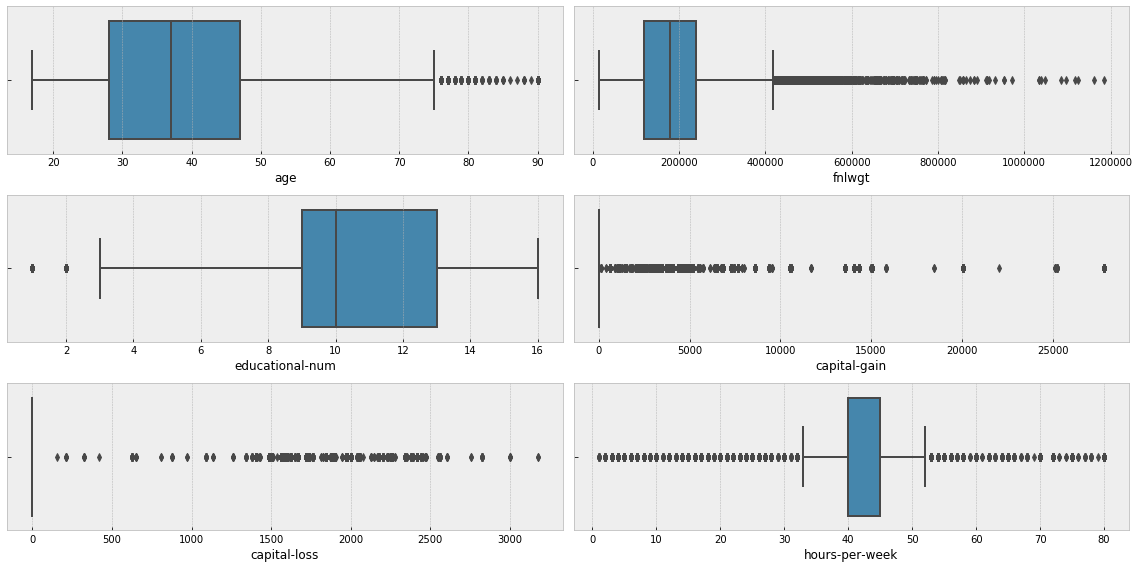

In [57]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(data[numeric_columns]):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        sns.boxplot(data[key])
        
    plt.tight_layout()

In [17]:
# удалим особенно сильные выбросы
data = data.loc[data['capital-gain'] <= 30000]
data = data.loc[data['fnlwgt'] <= 1200000]
data = data.loc[data['capital-loss'] <= 3500]
data = data.loc[data['hours-per-week'] <= 80]

### Подготовка данных

In [19]:
from sklearn.preprocessing import LabelEncoder

# 0: <=50K; 1: >50K;
le = LabelEncoder()
data['income'] = le.fit_transform(data['income'])

In [20]:
X = pd.concat((pd.get_dummies(data[categorial_columns].iloc[:,:-1]), data[numeric_columns]), axis=1)
y = data['income']

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 11)

### Построение модели - Дерево решений

In [61]:
from sklearn.tree import DecisionTreeClassifier

In [242]:
from sklearn.model_selection import GridSearchCV

grid_param = {
    'max_depth': [10, 20, 50, 100],
    'max_features': [20, 50, 100],
    'max_leaf_nodes': [10, 20, 50, 100, 200]
}

gd_sr = GridSearchCV(estimator=dtc,
                     param_grid=grid_param, # Проверяем гиперпарметры
                     cv=5,
                     n_jobs=-1
                    )

gd_sr.fit(X_train, y_train)
gd_sr.best_params_

{'max_depth': 50, 'max_features': 100, 'max_leaf_nodes': 100}

In [62]:
dtc = DecisionTreeClassifier(max_depth=50, max_features=100, max_leaf_nodes=100)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=50, max_features=100, max_leaf_nodes=100,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [72]:
from sklearn.metrics import roc_auc_score
dtc_score = roc_auc_score(y_test, dtc.predict_proba(X_test)[:,1])
print('ROC AUC score для Дерева Решений: {:.2f}'.format(dtc_score))

ROC AUC score для Дерева Решений: 0.91


http://www.webgraphviz.com

In [ ]:
from sklearn.tree import export_graphviz

def get_tree_dot_view(clf, feature_names=None, class_names=None):
    print(export_graphviz(clf, out_file=None, filled=True, feature_names=feature_names, class_names=class_names))
    
Graph = get_tree_dot_view(dtc)

### Построение модели - Случайный лес

In [236]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()

In [243]:
grid_param = {
    'n_estimators': [20, 50, 100, 200, 300],
    'max_depth': [10, 20, 50, 100],
    'max_features': [20, 50, 100],
    'max_leaf_nodes': [10, 20, 50, 100, 200],
    'bootstrap': [True, False]
}

gd_sr = GridSearchCV(estimator=rfc,
                     param_grid=grid_param, # Проверяем гиперпарметры
                     cv=5,
                     n_jobs=-1
                    )

gd_sr.fit(X_train, y_train)
gd_sr.best_params_

{'bootstrap': True,
 'max_depth': 50,
 'max_features': 50,
 'max_leaf_nodes': 200,
 'n_estimators': 100}

In [58]:
rfc_score = roc_auc_score(y_test, gd_sr.best_estimator_.predict_proba(X_test))
print('ROC AUC score для Случайного леса: {:.2f}'.format(rfc_score))

NameError: name 'roc_auc_score' is not defined

### Построение модели - GradientBoostingClassifier

In [249]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()

In [271]:
grid_param = {
    'n_estimators': [50, 200],
    'max_depth': [3, 5, 10]
}

gs_gbc = GridSearchCV(estimator=gbc,
                     param_grid=grid_param, # Проверяем гиперпарметры
                     cv=5,
                     n_jobs=-1
                    )

gs_gbc.fit(X_train, y_train)gs_gbc.best_params_

{'max_depth': 5, 'n_estimators': 200}

In [275]:
gbc_score = roc_auc_score(y_test, gs_gbc.best_estimator_.predict(X_test))
print('ROC AUC score для Случайного леса: {:.2f}'.format(gbc_score))

ROC AUC score для Случайного леса: 0.80


### Визуализация качества трех алгоритмов

In [86]:
from sklearn.metrics import roc_curve

In [87]:
dtc_fpr, dtc_tpr, dtc_thresholds = roc_curve(y_test, dtc.predict(X_test))
rfc_fpr, rfc_tpr, rfc_thresholds = roc_curve(y_test, gd_sr.best_estimator_.predict(X_test))
gbc_fpr, gbc_tpr, gbc_thresholds = roc_curve(y_test, gs_gbc.best_estimator_.predict(X_test))

NameError: name 'gd_sr' is not defined

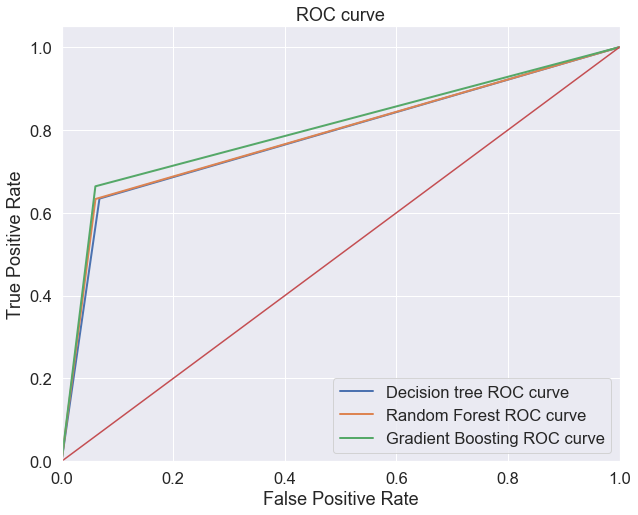

In [325]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")
plt.figure(figsize=(10, 8))

plt.plot(dtc_fpr, dtc_tpr, lw = 2, label='Decision tree ROC curve')
plt.plot(rfc_fpr, rfc_tpr, lw = 2, label='Random Forest ROC curve')
plt.plot(gbc_fpr, gbc_tpr, lw = 2, label='Gradient Boosting ROC curve')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

### CatBoost

In [45]:
!pip install catboost

     |████████████████████████████████| 10.9 MB 384 kB/s eta 0:00:01    |███████████▉                    | 4.0 MB 306 kB/s eta 0:00:23
     |████████████████████████████████| 12.9 MB 319 kB/s eta 0:00:01
  Using cached retrying-1.3.3.tar.gz (10 kB)
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11430 sha256=0751277fb6278b3844e602058a767dc509fcf77e383c31d9a447dd0787ea3e18
  Stored in directory: /Users/paulpolz/Library/Caches/pip/wheels/c4/a7/48/0a434133f6d56e878ca511c0e6c38326907c0792f67b476e56
Successfully built retrying


In [46]:
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [48]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

In [73]:
cat_model = CatBoostClassifier(logging_level='Silent')
cat_model.fit(X_train, y_train)
accuracy_score(y_test, cat_model.predict(X_test))

0.8744404655326768

In [76]:
cat_score = roc_auc_score(y_test, cat_model.predict_proba(X_test)[:,1])
print('ROC AUC score для CatBoost: {:.2f}'.format(cat_score))

ROC AUC score для CatBoost: 0.93


In [94]:
from sklearn.metrics import roc_curve

tpr, fpr, threshhold = roc_curve(y_test, cat_model.predict_proba(X_test)[:,1])

In [96]:
dtc_fpr, dtc_tpr, dtc_thresholds = roc_curve(y_test, dtc.predict_proba(X_test)[:,1])

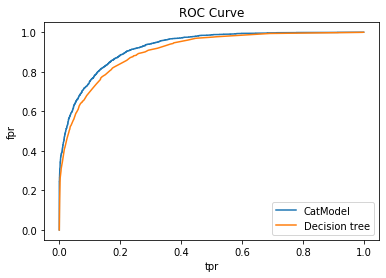

In [100]:
plt.title('ROC Curve')
plt.plot(tpr, fpr, label='CatModel')
plt.plot(dtc_fpr, dtc_tpr, label='Decision tree')
plt.xlabel('tpr')
plt.ylabel('fpr')
plt.legend();